In [1]:
# Импорт библиотек
import pandas as pd
import datetime
import numpy as np

from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier as GBC

import numpy as np
from matplotlib import pyplot as plt

# Подход 1. Градиентный бустинг "в лоб"

## 1. Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

In [3]:
# Чтение файла с обучающей выборкой
f_train = pd.read_csv("C:/Users/Хеллоу/Desktop/Финальное задание/features/features.csv") # Таблица с тренировочными данными
# Чтение файла с тестовой выборкой
f_test = pd.read_csv("C:/Users/Хеллоу/Desktop/Финальное задание/features_test/features_test.csv") # Таблица с тестовыми данными

x_test = f_test.drop(columns=["start_time"], axis=1) # Матрица признаков тестовой выборки с исключенным столбцом времени начала игр
y_train = f_train["radiant_win"] # Матрица объектов результатов игры для обучающей выборки
x_train = f_train.drop(columns=["radiant_win", "start_time"], axis=1) # Матрица признаков с исключенными столбцами результатов игр и временем начала игр

print("Признаки, связанные с итогами матча:", "\n")

# Исключение столбцов, отсутствующих в тестовой выборке из обучающей
for i in x_train.columns:
  if i not in x_test:
    print(i)
    x_train = x_train.drop([i], axis=1)

Признаки, связанные с итогами матча: 

duration
tower_status_radiant
tower_status_dire
barracks_status_radiant
barracks_status_dire


## 2. Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены. 

In [4]:
# Поиск и вывод признаков со значениями NaN:
count_0 = x_train.count()
print("Признаки с пропущенными значениями:", "\n")
count_0[count_0 < len(x_train)]

Признаки с пропущенными значениями: 



first_blood_time               77677
first_blood_team               77677
first_blood_player1            77677
first_blood_player2            53243
radiant_bottle_time            81539
radiant_courier_time           96538
radiant_flying_courier_time    69751
radiant_first_ward_time        95394
dire_bottle_time               81087
dire_courier_time              96554
dire_flying_courier_time       71132
dire_first_ward_time           95404
dtype: int64

   В признаке "first_blood_time" пропущены значения в том случае, если в первые 5 минут игры не было совершено убийство одного игрока другим.
   
   В признаке "radiant_first_ward_time" пропущены значения в том случае, если команда "radiant" не поставила наблюдателя в первые 5 минут игры.

## 3. Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой. 

In [5]:
# Заполнение пропусков тренировочной выборки средними значениями
x_train = x_train.fillna(x_train.mean())

## 4. Какой столбец содержит целевую переменную? Запишите его название.

   Целевую переменную содержит столбец "radiant_win".

## 5. Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

In [6]:
# Обозначаем генератор разбиений для кросс-валидации по 5 блокам (n_splits=5) с перемешиванием (shuffle=True)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Создаём цикл, в котором поочередно будет использоваться разное количество деревьев (n_estimators)
estimators_list = [10, 20, 30, 50, 100, 200] # Список набора деревьев
scores = {} # Создаем словарь для хранения результатов оценки по шаблону "количество деревьев: метрика"

for estimators in estimators_list: # Обозначение цикла
    start_time = datetime.datetime.now() # Время в моменте начала шага цикла
    gradient_boost = GBC(n_estimators=estimators, random_state=241, verbose=0) # Обозначение классификатора градиентного бустинга
    gradient_boost.fit(x_train, y_train) # Обучение градиентного бустинга
    CVS = cross_val_score(gradient_boost, x_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1).mean() # Вычисление метрики AUC-ROC градиентного бустинга с помощью оценщика cross_val_score
    scores[estimators] = CVS # В этом словаре хранятся метрики AUC-ROC
    
    # Вывод результатов рассчётов оценщика и времени выполнения шага цикла
    print(CVS, "n =", estimators)
    print(f"Time elapsed: {datetime.datetime.now() - start_time}")     

0.6632228421444619 n = 10
Time elapsed: 0:00:25.268059
0.6819913586442908 n = 20
Time elapsed: 0:00:48.870659
0.6889354624674262 n = 30
Time elapsed: 0:01:09.457550
0.6969997559715078 n = 50
Time elapsed: 0:01:56.765490
0.7061624577083627 n = 100
Time elapsed: 0:03:45.654564
0.7136044385288242 n = 200
Time elapsed: 0:07:22.385188


Text(0, 0.5, 'Метрика качества классификатора')

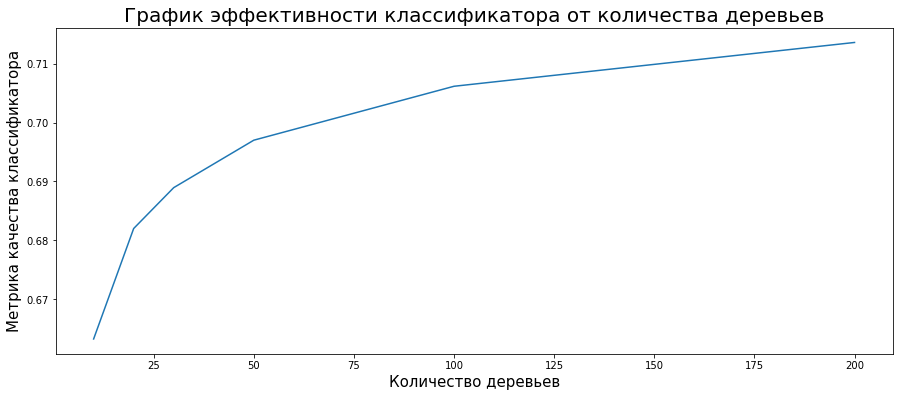

In [7]:
# Изображение зависимости качества классификатора от количества решающих деревьев
gb_graph = plt
gb_graph.figure(figsize=(15, 6))
gb_graph.plot(scores.keys(), scores.values())
gb_graph.title("График эффективности классификатора от количества деревьев", fontsize=20)
gb_graph.xlabel("Количество деревьев", fontsize=15)
gb_graph.ylabel("Метрика качества классификатора", fontsize=15)

   При 30 решающих деревьях качество классификатора достигло значения 0.689, длительность обучения и кросс-валидации заняла 1 минуту 5 секунд. Длительность зависит от мощностей процессора. Качество продолжит расти при увеличении количества деревьев, но эффективность касаемо соотношения качества и длительности будет падать. 
   
   Для увеличения скорости вычислений, нужно использовать всю производительность процессора (n_jobs в cross_val_score), можно уменьшить число блоков в генераторе KFold, к примеру, с 3 блоками качество упадет незначительно, в моём случае при 30 решающих деревьях и 3 блоках KFold затраченное время составило: 53 секунды, качество: 0.689, можно заметить, что качество осталось тем же, но время сократилось на 18%. Хочется отметить, что при 200 решающих деревьях разница во времени вычислений составила 1 минуту 48 секунд и качество получилось абсолютно таким же.
   
   Большое влияние на скорость оказывает глубина max_depth, в моём случае при уменьшении значения со стандартных 3 до 2: время составило 49 секунд и качество 0.682.
   
   Можно уменьшить размер обучающей выборки, подбирая оптимальное значение.

 # Подход 2. Логистическая регрессия

## 1. Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

In [8]:
# Подготовка данных к использованию в логистической регрессии

# Изменение формата на np.array
x_train_values = x_train.values 
y_train_values = y_train.values.reshape(-1, 1) # Изменение матрицы объектов от вида (1, XXXXX) к виду (XXXXX, 1)

# Нормирование данных для линейных классификаторов
scaler = StandardScaler()
x_train_values = scaler.fit_transform(x_train_values)

scores_lr = {}

# Обозначаем генератор разбиений для кросс-валидации по 5 блокам (n_splits=5) с перемешиванием (shuffle=True)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Цикл подбора параметра регуляризации C
for degree in range(-5, 6):
    start_time = datetime.datetime.now() # Время в моменте начала шага цикла
    C = 10 ** degree
    
    LR = LogReg(C=C, random_state=241) # Обозначаем классификатор логистической регрессии
    CVS_lr = cross_val_score(estimator=LR, X=x_train_values, y=y_train_values, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
    scores_lr[degree] = CVS_lr # В этом словаре хранятся метрики AUC-ROC
    
    # Вывод результатов рассчётов оценщика и времени выполнения шага цикла
    print(CVS_lr, "C =", C)
    print(f"Time elapsed: {datetime.datetime.now() - start_time}")     

0.6945715820463141 C = 1e-05
Time elapsed: 0:00:01.919614
0.7121443888079603 C = 0.0001
Time elapsed: 0:00:01.089844
0.7168842623152404 C = 0.001
Time elapsed: 0:00:01.986656
0.7170409699322036 C = 0.01
Time elapsed: 0:00:02.510493
0.7170198396899601 C = 0.1
Time elapsed: 0:00:02.566267
0.7170163802572395 C = 1
Time elapsed: 0:00:02.823847
0.7170161197614487 C = 10
Time elapsed: 0:00:02.729152
0.7170155435031489 C = 100
Time elapsed: 0:00:02.651286
0.7170155329137414 C = 1000
Time elapsed: 0:00:02.651750
0.7170155350326212 C = 10000
Time elapsed: 0:00:02.484300
0.717015530795108 C = 100000
Time elapsed: 0:00:02.498129


Text(0, 0.5, 'Метрика качества классификатора')

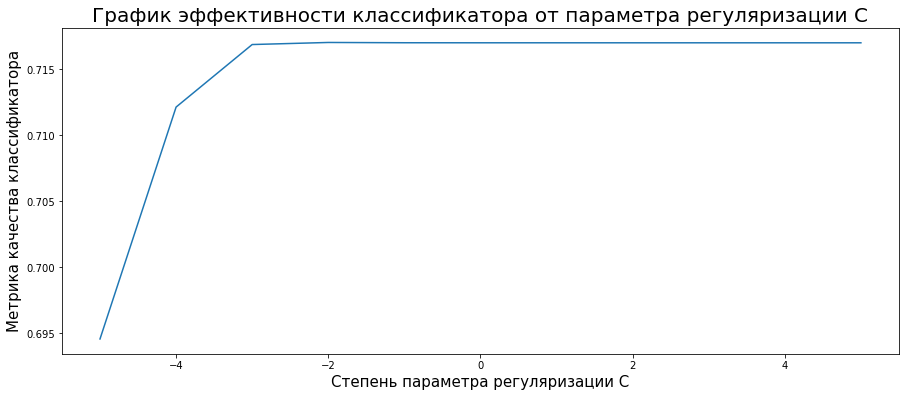

In [9]:
# Изображение зависимости качества классификатора от величины параметра регуляризации
lr_graph = plt
lr_graph.figure(figsize=(15, 6))
lr_graph.plot(scores_lr.keys(), scores_lr.values())
lr_graph.title("График эффективности классификатора от параметра регуляризации C", fontsize=20)
lr_graph.xlabel("Степень параметра регуляризации C", fontsize=15)
lr_graph.ylabel("Метрика качества классификатора", fontsize=15)

    Наилучшее качество, которое получилось: 0.7170409699322036, оно было достигнуто при значении параметра регуляризации равном 0.01. Качество логистической регрессии выше, чем качество градиентного бустинга с очень большим количеством решающих деревьев. Думаю разница может быть объяснена тем, что для логистической регрессии данные проходят более качественную подготовку.
    
    Логистическая регрессия работает намного быстрее, чем градиентный бустинг, особенно в моменте достижения максимального качества классификатора.

## 2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

In [10]:
# Удаляем категориальные признаки из обучающей выборки

hero_columns = ["r1_hero", "r2_hero", "r3_hero", "r4_hero", "r5_hero", "d1_hero", "d2_hero", "d3_hero", "d4_hero", "d5_hero"]
dropping_columns = ["lobby_type"] + hero_columns
x_train.drop(dropping_columns, axis=1) # Исключаем из выборки столбцы с категориальными признаками


# Подготавливаем данные
scaler = StandardScaler()

x_train_values = x_train.values
x_train_values = scaler.fit_transform(x_train_values)

# Целевая переменная осталась неизменна, её оставляем нетронутой

scores_lr = {}

# Цикл подбора параметра регуляризации C
for degree in range(-5, 6):
    start_time = datetime.datetime.now() # Время в моменте начала шага цикла
    C = 10 ** degree
    
    LR = LogReg(C=C, random_state=241) # Обозначаем классификатор логистической регрессии
    CVS_lr = cross_val_score(estimator=LR, X=x_train_values, y=y_train_values, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
    scores_lr[degree] = CVS_lr # В этом словаре хранятся метрики AUC-ROC
    
    # Вывод результатов рассчётов оценщика и времени выполнения шага цикла
    print(CVS_lr, "C =", C)
    print(f"Time elapsed: {datetime.datetime.now() - start_time}")     

0.6945715820463141 C = 1e-05
Time elapsed: 0:00:01.058667
0.7121443888079603 C = 0.0001
Time elapsed: 0:00:01.113194
0.7168842623152404 C = 0.001
Time elapsed: 0:00:01.758042
0.7170409699322036 C = 0.01
Time elapsed: 0:00:02.317992
0.7170198396899601 C = 0.1
Time elapsed: 0:00:02.902128
0.7170163802572395 C = 1
Time elapsed: 0:00:02.602427
0.7170161197614487 C = 10
Time elapsed: 0:00:02.556196
0.7170155435031489 C = 100
Time elapsed: 0:00:02.565360
0.7170155329137414 C = 1000
Time elapsed: 0:00:02.464990
0.7170155350326212 C = 10000
Time elapsed: 0:00:02.543886
0.717015530795108 C = 100000
Time elapsed: 0:00:02.628492


Text(0, 0.5, 'Метрика качества классификатора')

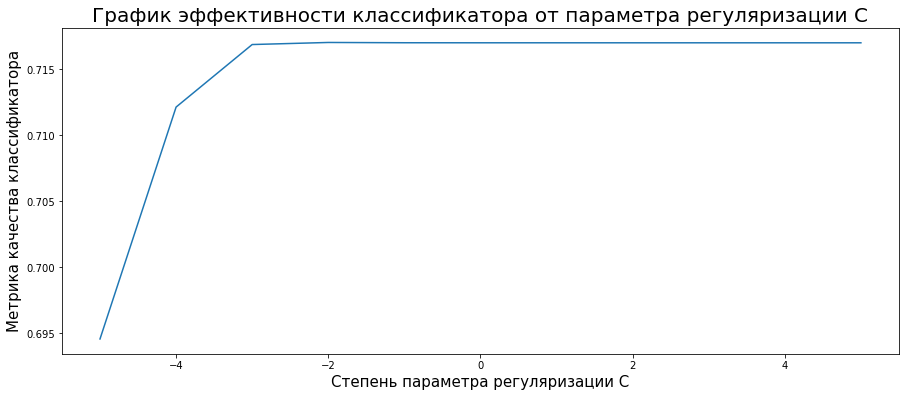

In [11]:
# Изображение зависимости качества классификатора от от величины параметра регуляризации
lr_graph = plt
lr_graph.figure(figsize=(15, 6))
lr_graph.plot(scores_lr.keys(), scores_lr.values())
lr_graph.title("График эффективности классификатора от параметра регуляризации C", fontsize=20)
lr_graph.xlabel("Степень параметра регуляризации C", fontsize=15)
lr_graph.ylabel("Метрика качества классификатора", fontsize=15)

    После удаления категориальных признаков качество модели не изменилось. Это можно объяснить тем, что они не влияют на эту модель.

## 3. На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться функция unique или value_counts).

In [12]:
unique_heroes = np.unique(x_train[hero_columns]) # Список уникальных id героев, участвовавших в выборке
N = max(unique_heroes) # Наибольший id среди героев
print("Уникальные id героев:", unique_heroes, f"Число уникальных героев: {len(unique_heroes)}. Общее количество id героев: {N}.", sep='\n\n')

Уникальные id героев:

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 109 110 112]

Число уникальных героев: 108. Общее количество id героев: 112.


## 4. Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данное преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.

In [13]:
# Создаем матрицу участия для героев (1 - играл за Radiant, 0 - не играл вообще, -1 - играл за Dire)
participate_np = np.zeros((x_train.shape[0], N)) # Сначала создаем матрицу формата numpy.array размером x_train.shape[0] * N
#(столбец match_id под номером 0 в x_train, shape - показывает размер столбца), N - общее количество id героев

# Заполняем таблицу участия героя в конкретном матче
for i, match_id in enumerate(x_train.index):
    for p in range(1, 6):
        participate_np[i, x_train.loc[match_id, 'r%d_hero' % p] - 1] = 1
        participate_np[i, x_train.loc[match_id, 'd%d_hero' % p] - 1] = -1

participate_df = pd.DataFrame(participate_np, index=[i for i in range(x_train.shape[0])], columns=[f"hero_{i}" for i in range(1, N + 1)])
# Создаем таблицу формата pandas.DataFrame, в котором номера строк (index) берем из match_id, номера столбцов (columns) по id героев
print(participate_df)

       hero_1  hero_2  hero_3  hero_4  hero_5  hero_6  hero_7  hero_8  hero_9  \
0         0.0     0.0     0.0    -1.0     0.0     0.0     0.0     0.0     0.0   
1         0.0     0.0     0.0     0.0     0.0     0.0    -1.0     0.0     0.0   
2         0.0     0.0     0.0     1.0     0.0     0.0     0.0     0.0     0.0   
3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4         0.0     0.0     0.0     0.0     0.0     0.0     0.0    -1.0     0.0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
97225     1.0     0.0    -1.0     0.0     0.0     0.0     1.0     0.0     0.0   
97226     0.0     0.0     0.0     1.0    -1.0     0.0     0.0     0.0     0.0   
97227     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
97228     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0    -1.0   
97229     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

       hero_10  ...  hero_1

In [14]:
# Добавляем мешок слов к выборке с числовыми признаками (выборка, из которой были удалены категориальные)
x_train = pd.concat([x_train, participate_df], axis=1)
print(x_train.head(5))

   match_id  lobby_type  r1_hero  r1_level  r1_xp  r1_gold  r1_lh  r1_kills  \
0         0           7       11         5   2098     1489     20         0   
1         1           0       42         4   1188     1033      9         0   
2         2           7       33         4   1319     1270     22         0   
3         3           1       29         4   1779     1056     14         0   
4         4           7       13         4   1431     1090      8         1   

   r1_deaths  r1_items  ...  hero_103  hero_104  hero_105  hero_106  hero_107  \
0          0         7  ...       0.0       0.0       1.0       0.0       0.0   
1          1        12  ...       0.0       0.0       0.0       0.0       0.0   
2          0        12  ...       0.0       0.0       0.0       0.0       0.0   
3          0         5  ...       0.0       0.0       0.0       0.0       0.0   
4          0         8  ...       0.0       0.0       0.0       0.0       0.0   

   hero_108  hero_109  hero_110  hero_

## 5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

In [15]:
x_train_values = x_train.values
x_train_values = scaler.fit_transform(x_train_values)

# Целевая переменная осталась неизменна, её оставляем нетронутой

scores_lr = {}

# Цикл подбора параметра регуляризации C
for degree in range(-5, 6):
    start_time = datetime.datetime.now() # Время в моменте начала шага цикла
    C = 10 ** degree
    
    LR = LogReg(C=C, random_state=241) # Обозначаем классификатор логистической регрессии
    CVS_lr = cross_val_score(estimator=LR, X=x_train_values, y=y_train_values, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
    scores_lr[degree] = CVS_lr # В этом словаре хранятся метрики AUC-ROC
    
    # Вывод результатов рассчётов оценщика и времени выполнения шага цикла
    print(CVS_lr, "C =", C)
    print(f"Time elapsed: {datetime.datetime.now() - start_time}")

0.713891554933227 C = 1e-05
Time elapsed: 0:00:01.923680
0.7430610706247276 C = 0.0001
Time elapsed: 0:00:01.898457
0.751753850560757 C = 0.001
Time elapsed: 0:00:03.440200
0.752095003139433 C = 0.01
Time elapsed: 0:00:05.366703
0.7520699357616246 C = 0.1
Time elapsed: 0:00:05.294519
0.7520649237419633 C = 1
Time elapsed: 0:00:05.166183
0.752064116646687 C = 10
Time elapsed: 0:00:05.205060
0.7520640954639519 C = 100
Time elapsed: 0:00:05.224962
0.7520640488589028 C = 1000
Time elapsed: 0:00:05.162272
0.7520640382662198 C = 10000
Time elapsed: 0:00:05.464999
0.7520640361477755 C = 100000
Time elapsed: 0:00:05.365551


Text(0, 0.5, 'Метрика качества классификатора')

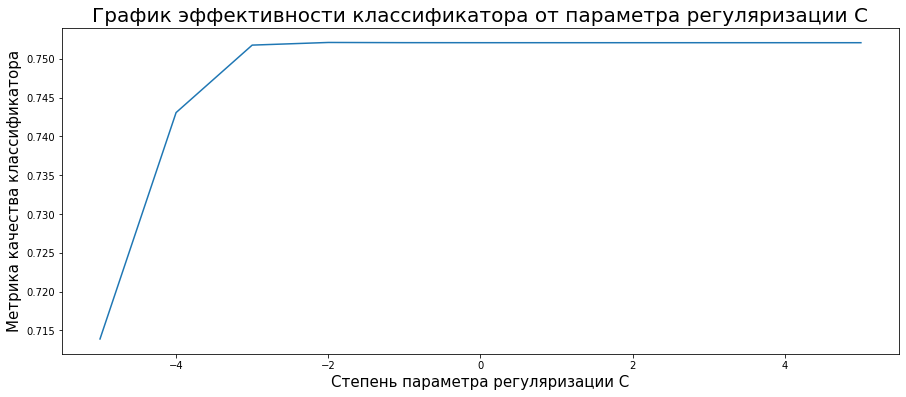

In [16]:
# Изображение зависимости качества классификатора от от величины параметра регуляризации
lr_graph = plt
lr_graph.figure(figsize=(15, 6))
lr_graph.plot(scores_lr.keys(), scores_lr.values())
lr_graph.title("График эффективности классификатора от параметра регуляризации C", fontsize=20)
lr_graph.xlabel("Степень параметра регуляризации C", fontsize=15)
lr_graph.ylabel("Метрика качества классификатора", fontsize=15)

Качество классификатора получилось 0.752 при параметре регуляризации равном 0.01. Оно ощутимо улучшилось. Это можно объяснить тем, что у модели появилось намного больше признаков, она стала обучаться более тщательно.

## 6. Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

In [17]:
# Поиск и вывод признаков со значениями NaN:
count = x_test.count()
print("Признаки с пропущенными значениями:", "\n")
count[count < len(x_test)]

# Заполнение пропусков тестовой выборки средними значениями
x_test = x_test.fillna(x_test.mean())

# Категориальные признаки
hero_columns = ["r1_hero", "r2_hero", "r3_hero", "r4_hero", "r5_hero", "d1_hero", "d2_hero", "d3_hero", "d4_hero", "d5_hero"]
dropping_columns = ["lobby_type"] + hero_columns

unique_heroes = np.unique(x_test[hero_columns]) # Список уникальных id героев, участвовавших в выборке
N = max(unique_heroes) # Наибольший id среди героев

print("Уникальные id героев:", unique_heroes, f"Число уникальных героев: {len(unique_heroes)}. Общее количество id героев: {N}.", sep='\n\n')

Признаки с пропущенными значениями: 

Уникальные id героев:

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 109 110 112]

Число уникальных героев: 108. Общее количество id героев: 112.


In [18]:
# Создаем матрицу участия для героев (1 - играл за Radiant, 0 - не играл вообще, -1 - играл за Dire)
participate_np = np.zeros((x_test.shape[0], N)) # Сначала создаем матрицу формата numpy.array размером x_train.shape[0] * N
#(столбец match_id под номером 0 в x_train, shape - показывает размер столбца), N - общее количество id героев
print("Нулевая матрица x_test.shape[0] * N", participate_np, sep="\n\n")
# Заполняем таблицу участия героя в конкретном матче
for i, match_id in enumerate(x_test.index):
    for p in range(1, 6):
        participate_np[i, x_test.loc[match_id, 'r%d_hero' % p] - 1] = 1
        participate_np[i, x_test.loc[match_id, 'd%d_hero' % p] - 1] = -1

participate_df = pd.DataFrame(participate_np, index=[i for i in range(x_test.shape[0])], columns=[f"hero_{i}" for i in range(1, N + 1)])
# Создаем таблицу формата pandas.DataFrame, в котором номера строк (index) берем из match_id, номера столбцов (columns) по id героев
print("Готовый мешок слов по участвующим в матчах героям", participate_df.head(5), sep="\n\n")

Нулевая матрица x_test.shape[0] * N

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Готовый мешок слов по участвующим в матчах героям

   hero_1  hero_2  hero_3  hero_4  hero_5  hero_6  hero_7  hero_8  hero_9  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0     0.0    -1.0     1.0     0.0     0.0     0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0    -1.0     0.0     0.0     0.0     0.0     0.0     0.0   

   hero_10  ...  hero_103  hero_104  hero_105  hero_106  hero_107  hero_108  \
0      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
1      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
2     -1.0  ...       0.0       0.0       0.0       0.0 

In [19]:
# Совмещаем мешок слов с тестовой выборкой
x_test = pd.concat([x_test, participate_df], axis=1)
print("Готовая тестовая выборка с мешком слов по героям", x_test.head(5), sep="\n\n")

Готовая тестовая выборка с мешком слов по героям

   match_id  lobby_type  r1_hero  r1_level  r1_xp  r1_gold  r1_lh  r1_kills  \
0         6           0       93         4   1103     1089      8         0   
1         7           1       20         2    556      570      1         0   
2        10           1      112         2    751      808      1         0   
3        13           1       27         3    708      903      1         1   
4        16           1       39         4   1259      661      4         0   

   r1_deaths  r1_items  ...  hero_103  hero_104  hero_105  hero_106  hero_107  \
0          1         9  ...       0.0       0.0       0.0       0.0       0.0   
1          0         9  ...       0.0       0.0       0.0       0.0       0.0   
2          0        13  ...       0.0       0.0       0.0       0.0       0.0   
3          1        11  ...       0.0       0.0       0.0       0.0       0.0   
4          0         9  ...       0.0       0.0       0.0       0.0   

In [47]:
# Нормализация признаков тестовой выборки
scaler = StandardScaler() # Объявление функции StandardScaler
x_test_values = x_test.values # Приведение pd.DataFrame к формату np.array
x_train_values = x_train.values # Приведение pd.DataFrame к формату np.array
y_train_values = y_train.values # Приведение pd.DataFrame к формату np.array
x_test_values = scaler.fit_transform(x_test_values) # Применение нормализации к тестовой выборке
x_train_values = scaler.fit_transform(x_train_values) # Применение нормализации к обучающей выборке

In [50]:
# Объявление модели логистической регрессии
model = LogReg(C=0.01, random_state=241)
# Обучение логистической регрессии
model.fit(x_train_values, y_train_values)

LogisticRegression(C=0.01, random_state=241)

In [51]:
# Предсказанные вероятности победы команды Radiant по тестовым данным
preds = pd.Series(model.predict_proba(x_test_values)[:, 1])
print(preds)

0        0.848813
1        0.747383
2        0.211569
3        0.851292
4        0.240609
           ...   
17172    0.736568
17173    0.638293
17174    0.245840
17175    0.609099
17176    0.445439
Length: 17177, dtype: float64


In [52]:
# Статистические данные предсказанных вероятностей
preds.describe()

count    17177.000000
mean         0.518491
std          0.220639
min          0.008946
25%          0.347338
50%          0.524293
75%          0.691680
max          0.996369
dtype: float64

Минимальная вероятность получилась 0.0089, а максимальная 0.9964, предсказанные вероятности находятся на отрезке [0, 1] и не совпадают друг с другом, следовательно модель не получилась константной

<AxesSubplot:ylabel='Frequency'>

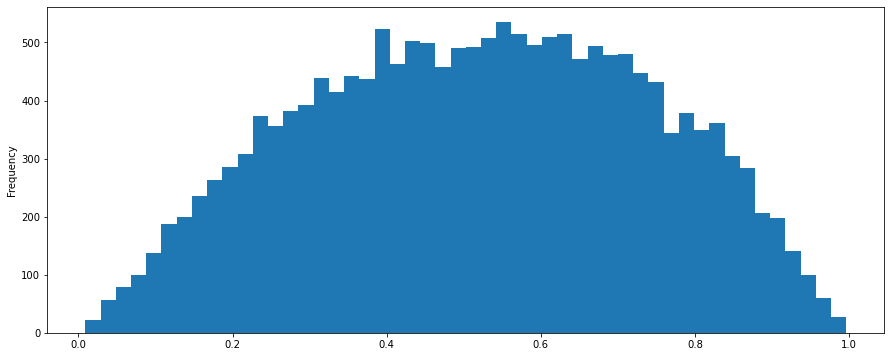

In [56]:
# График частоты предсказанных вероятностей
preds.plot.hist(bins=50, figsize=(15, 6))